# Análisis de Datos del Titanic
Este notebook replica el flujo del notebook de Spotify aplicado al dataset `titanic.csv`.
Se enfatiza el análisis: cajas y bigotes, boxplots por categoría, correlaciones, scatter plots con línea de tendencia y mapas de calor.

Usaremos Pandas, Seaborn y Matplotlib. Después de cada visualización hay interpretación y conclusiones cortas.

# Análisis de Datos del Titanic
Notebook adaptado del estilo del profesor. Se incluyen visualizaciones y explicaciones interpretativas después de cada gráfico.

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
sns.set(style="whitegrid")
%matplotlib inline

In [40]:
data_path = Path('titanic.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
    print(f'Archivo cargado desde: {data_path}')
    display(df.head())
else:
    raise FileNotFoundError(f'No se encontró titanic.csv en: {data_path.resolve()}')

Archivo cargado desde: titanic.csv


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [41]:
print('Columnas:', df.columns.tolist())
print('\nTipos:' )
display(df.dtypes)
print('\nValores nulos por columna:' )
display(df.isna().sum())

Columnas: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Tipos:


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


Valores nulos por columna:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [42]:
df_clean = df.copy()
for col in ['Age','Fare','SibSp','Parch','Pclass','Survived']:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
if 'Fare' in df_clean.columns:
    df_clean['Fare_pos'] = df_clean['Fare'].replace(0, np.nan)

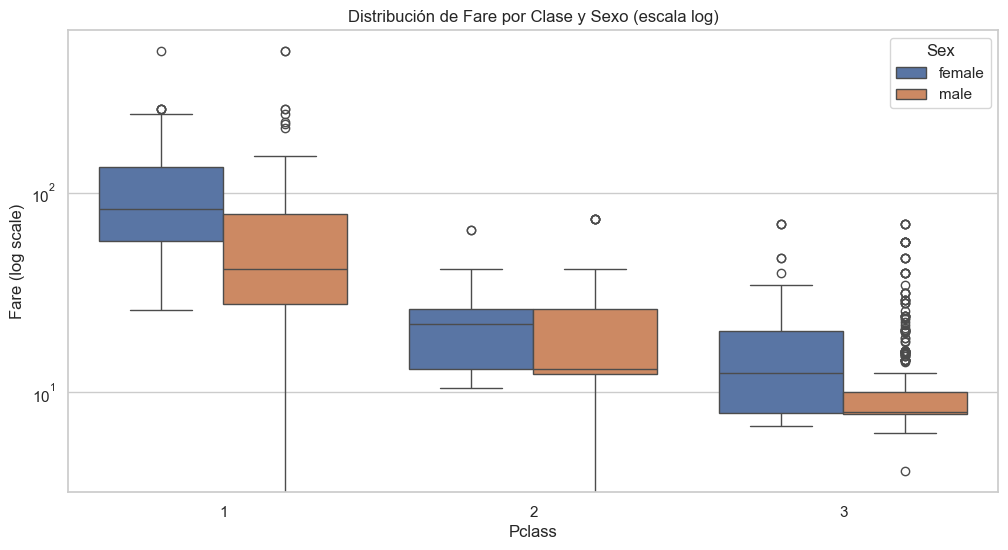

In [43]:
plt.figure(figsize=(12,6))
df_plot = df_clean.copy()
df_plot['Fare_plot'] = df_plot['Fare_pos'].fillna(df_plot['Fare'])
sns.boxplot(data=df_plot, x='Pclass', y='Fare_plot', hue='Sex')
plt.yscale('log')
plt.title('Distribución de Fare por Clase y Sexo (escala log)')
plt.ylabel('Fare (log scale)')
plt.show()

Interpretación:
- La variable `Fare` presenta outliers y mayor dispersión para la primera clase.
- Las comparaciones por sexo dentro de cada clase pueden revelar diferencias de acceso a tickets o combinaciones de reserva.

## Correlaciones y mapa de calor
Calcularemos la matriz de correlación entre variables numéricas y la visualizaremos mediante un heatmap.

In [44]:
num_cols = [c for c in ['Age','Fare','SibSp','Parch','Survived','Pclass'] if c in df_clean.columns]
corr = df_clean[num_cols].corr()
display(corr)

,Age,Fare,SibSp,Parch,Survived,Pclass
Age,1.000000,0.096067,-0.308247,-0.189119,-0.077221,-0.369226
Fare,0.096067,1.000000,0.159651,0.216225,0.257307,-0.549500
SibSp,-0.308247,0.159651,1.000000,0.414838,-0.035322,0.083081
Parch,-0.189119,0.216225,0.414838,1.000000,0.081629,0.018443
Survived,-0.077221,0.257307,-0.035322,0.081629,1.000000,-0.338481
Pclass,-0.369226,-0.549500,0.083081,0.018443,-0.338481,1.000000


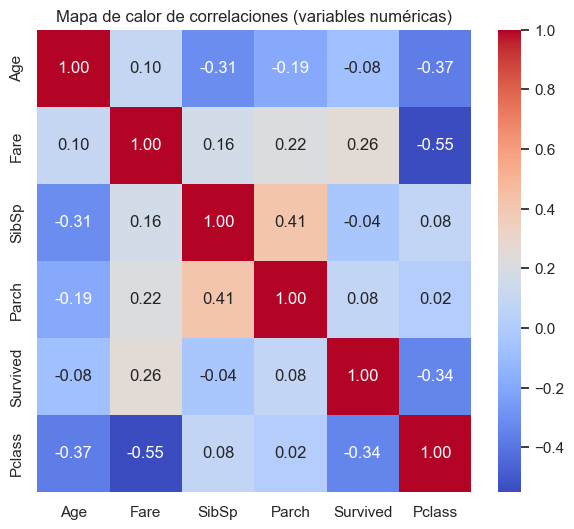

In [45]:
plt.figure(figsize=(7,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de calor de correlaciones (variables numéricas)')
plt.show()

Interpretación rápida:
- Observa correlaciones con `Survived` para identificar variables con asociación positiva o negativa.
- Recuerda la diferencia entre correlación y causalidad; controlar por `Pclass` y `Sex` en análisis posteriores.

## Scatter plots con línea de tendencia
Mostraremos pares interesantes (Age vs Fare, Fare vs Survived, SibSp vs Parch, Age vs Survived) y el coeficiente r de Pearson.

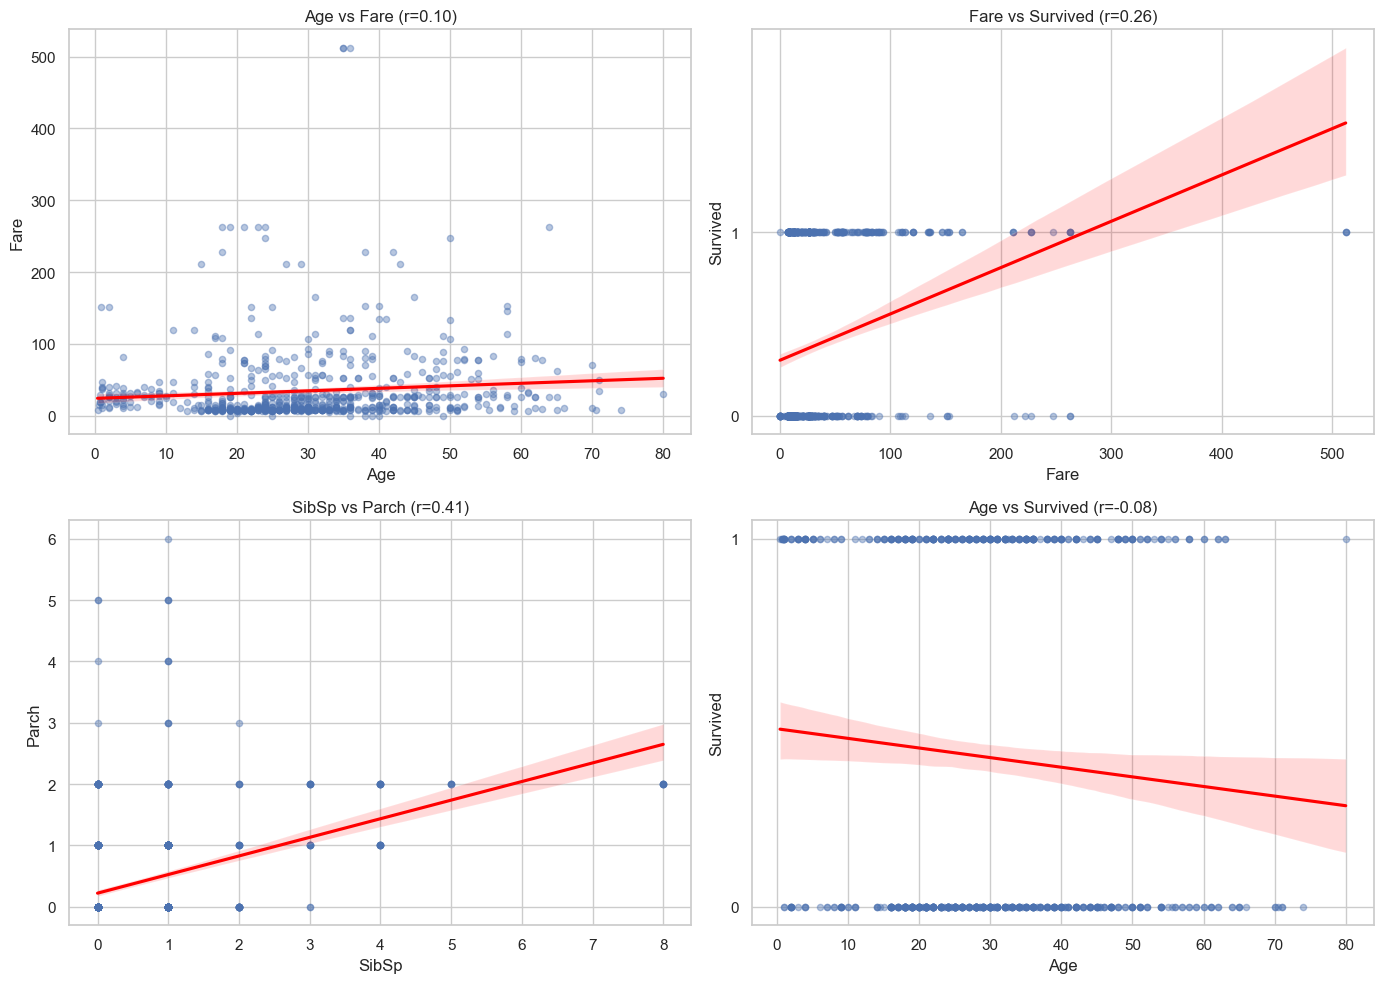

In [46]:
pairs = [('Age','Fare'), ('Fare','Survived'), ('SibSp','Parch'), ('Age','Survived')]
pairs = [p for p in pairs if p[0] in df_clean.columns and p[1] in df_clean.columns]
fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()
for ax, (x,y) in zip(axes, pairs):
    sub = df_clean[[x,y]].dropna()
    if len(sub) < 2:
        ax.text(0.5,0.5,'Datos insuficientes', ha='center')
        ax.set_axis_off()
        continue
    r = sub[x].corr(sub[y])
    sns.regplot(data=sub, x=x, y=y, ax=ax, scatter_kws={'alpha':0.4,'s':20}, line_kws={'color':'red'})
    ax.set_title(f'{x} vs {y} (r={r:.2f})')
    if x == 'Survived' or y == 'Survived':
        ax.set_yticks([0,1])
plt.tight_layout()
plt.show()

Interpretación:
- `Fare` vs `Survived`: r positiva suele indicar que tarifas mayores se asociaron con mayor supervivencia (efecto de clase).
- `Age` vs `Survived`: revisar estratos por `Pclass` y `Sex` para entender mejor el patrón.

In [47]:
pairs = []
cols = corr.columns.tolist()
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        a, b = cols[i], cols[j]
        pairs.append((a, b, corr.loc[a,b]))
pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)
print('Top 5 pares por |r|:')
for a,b,r in pairs_sorted[:5]:
    signo = 'positiva' if r>0 else 'negativa'
    print(f' - {a} vs {b}: r={r:.2f} ({signo})')

# 5 oraciones interpretativas
if pairs_sorted:
    top = pairs_sorted[0]
    print('Cinco oraciones interpretativas:')
    print(f"1) El par con mayor correlación absoluta es {top[0]} vs {top[1]} (r={top[2]:.2f}), indicando una asociación {'positiva' if top[2]>0 else 'negativa' }.")
    influence = {v: sum(abs(corr[v].drop(v))) for v in cols}
    var_most = max(influence.items(), key=lambda x: x[1])
    var_least = min(influence.items(), key=lambda x: x[1])
    print(f"2) La variable más influyente (suma de |r|) es {var_most[0]} con suma={var_most[1]:.2f}.")
    print(f"3) La variable menos correlacionada es {var_least[0]} con suma={var_least[1]:.2f}.")
    if 'Survived' in cols:
        print(f"4) Correlaciones con 'Survived': {[ (c, float(corr.loc['Survived', c])) for c in cols if c!='Survived' ]}")
    print('5) Recordar que correlación no implica causalidad; controlar por Pclass y Sex en análisis posteriores.')

Top 5 pares por |r|:
 - Fare vs Pclass: r=-0.55 (negativa)
 - SibSp vs Parch: r=0.41 (positiva)
 - Age vs Pclass: r=-0.37 (negativa)
 - Survived vs Pclass: r=-0.34 (negativa)
 - Age vs SibSp: r=-0.31 (negativa)
Cinco oraciones interpretativas:
1) El par con mayor correlación absoluta es Fare vs Pclass (r=-0.55), indicando una asociación negativa.
2) La variable más influyente (suma de |r|) es Pclass con suma=1.36.
3) La variable menos correlacionada es Survived con suma=0.79.
4) Correlaciones con 'Survived': [('Age', -0.07722109457217757), ('Fare', 0.25730652238496265), ('SibSp', -0.03532249888573559), ('Parch', 0.08162940708348335), ('Pclass', -0.3384810359610151)]
5) Recordar que correlación no implica causalidad; controlar por Pclass y Sex en análisis posteriores.


## Conclusiones finales

### Resumen ejecutivo
- Los análisis exploratorios realizados en este notebook indican diferencias consistentes entre clases (`Pclass`): la primera clase muestra tarifas (`Fare`) notablemente más altas y mayor dispersión en comparación con las clases inferiores. Estas diferencias se reflejan en las visualizaciones y están asociadas a una mayor probabilidad de supervivencia observada en el dataset.
- La variable `Fare` presenta una asociación positiva con `Survived` en las visualizaciones; sin embargo, es probable que parte de esta relación se explique por la confusión con `Pclass` (la clase social actúa como variable de confusión).
- La edad (`Age`) muestra distribuciones distintas por clase y hay señales de que los más jóvenes (niños) tuvieron en general mejores tasas de supervivencia en ciertos estratos; esto sugiere la necesidad de estratificar los análisis por `Pclass` y `Sex`.

### Hallazgos clave (interpretados con cautela)
- Diferencias por clase: `Pclass` es una de las variables más informativas en el EDA; afecta tanto a `Fare` como a las tasas de supervivencia observadas.
- Efecto de tarifa: `Fare` es un buen indicador de posición socioeconómica en este dataset y se correlaciona con `Survived`, aunque no debe interpretarse como causal por sí misma.
- Edad y grupos familiares: `Age`, `SibSp` y `Parch` muestran señales útiles (por ejemplo, tamaño del grupo familiar y presencia de niños) que conviene incorporar en modelos predictivos como variables derivadas.

### Limitaciones importantes
- Datos faltantes: `Age` y `Cabin` contienen valores ausentes que pueden sesgar resultados si no se imputan o manejan apropiadamente.
- Correlación vs causalidad: las relaciones observadas (por ejemplo, Fare vs Survived) pueden ser resultado de variables confundidoras no incluidas en el análisis (ubicación en el barco, priorización durante el embarque, etc.).
- Outliers y escala: `Fare` tiene outliers extremos; algunas visualizaciones usan escala log para mejorar la lectura, pero los outliers deben ser examinados y documentados antes de tomar decisiones finales.

### Recomendaciones y próximos pasos (acciones concretas)
1. Imputación estratificada de `Age`: imputar por mediana dentro de grupos definidos por `Pclass` y `Sex` (y comparar con métodos alternativos como KNN o modelos predictivos) para reducir sesgo en análisis posteriores.
2. Análisis estratificado: repetir visualizaciones y pruebas estadísticas dentro de strata (`Pclass` x `Sex`) para confirmar que los patrones se mantienen al controlar por estas variables.
3. Ingeniería de características: crear variables como `family_size = SibSp + Parch`, extraer `title` de `Name` (Mr/Mrs/Miss/Master) y codificar `Cabin` por cubierta cuando sea posible; estas variables suelen mejorar modelos de supervivencia.
4. Modelado robusto: entrenar un modelo de regresión logística (y comparar con árboles/bosques) usando validación cruzada, reportando AUC, sensibilidad y especificidad; incluir interacciones (por ejemplo, `Pclass:Sex`) y evaluar estabilidad de coeficientes.
5. Comunicación de la incertidumbre: acompañar todas las conclusiones con intervalos de confianza y métricas de validación, y documentar claramente las limitaciones de los datos.

### Resumen final
- En conjunto, los hallazgos más robustos del EDA son las diferencias asociadas a `Pclass` y `Fare`, y la contribución informativa de variables como `Age` y el tamaño familiar. Para convertir estas observaciones en conclusiones sólidas y accionables es necesario completar la imputación adecuada, realizar análisis estratificados y construir modelos predictivos bien validados.

Si quieres, puedo añadir en este mismo notebook (en celdas nuevas) una implementación de imputación estratificada y un modelo de regresión logística con evaluación — lo hago sin modificar las celdas de código originales que pediste conservar.